In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.transforms import GaussianBlur, ToTensor, ToPILImage, RandomCrop, Compose, Resize, Normalize
from torchvision.datasets import CIFAR10, Flickr8k, CelebA
from torch.utils.data import DataLoader

# Set device
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001
image_size = 28

# Gaussian Pyramid Constants
num_scales = 3
scale_factor = 2

# Define the transformations to apply to the CIFAR-10 data
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

download = True
# Define the training and test datasets
train_dataset = datasets.Flowers102(root='./data', split="train", download=download, transform=data_transforms)

# Define the dataloaders to load the data in batches during training and testing
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader = train_loader

In [2]:
# Define the network architecture with feature pyramid
class CompletionModel(nn.Module):
    def __init__(self, num_scales=3):
        super(CompletionModel, self).__init__()
        self.num_scales = num_scales

        # Define layers for each scale in the feature pyramid
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.channel_reducers = nn.ModuleList()  # 1x1 convolution layers to reduce channels
#         self.downsamplers = nn.ModuleList()
#         self.upsamplers = nn.ModuleList()
        
        for i in range(num_scales):
            encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            )
            self.encoders.append(encoder)

            decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            )
            self.decoders.append(decoder)
            
            channel_reducer = nn.Conv2d(3, 512, kernel_size=1)  # 1x1 convolution layer to reduce channels
            self.channel_reducers.append(channel_reducer)
            
        self.upsampler = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)
        self.downsampler = nn.Upsample(scale_factor=1/scale_factor, mode='bilinear', align_corners=False)
            

    def forward(self, x):
        # Initialize list to store features from each scale
        features = []
        #print(f"x.shape: {x.shape}")

        # Forward pass through each scale in the feature pyramid
        for i in range(self.num_scales):
            encoder_output = self.encoders[i](x)
            features.append(encoder_output)
            #print(f"Feature size at {i}th scale: {features[-1].shape}")
            x = self.downsampler(x)

        # Decode the concatenated features
        shape_feats = list(features[-1].shape)
        shape_feats[1] = 3
        prev_output = None#torch.zeros(shape_feats).to(device)
        
        for i in range(self.num_scales):
            decoder_output = self.decoders[i](features[self.num_scales - i - 1])
            #print(f"decoder output shape: {decoder_output.shape}")
            if prev_output is None:
                prev_output = self.upsampler(decoder_output)
            else:
                #prev_output = self.channel_reducers[i](prev_output)
                prev_output = self.upsampler(prev_output+decoder_output)
            #print(f"prev_output.shape : {prev_output.shape}")
        
        #print(decoder_output.shape)
        return decoder_output


In [3]:
model = CompletionModel().to(device)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        # Forward pass and loss calculation
        completion_images = model(occluded_image.to(device))
        loss = criterion(completion_images[:, :, y:y + h // 2, x:x + w // 2], images[:, :, y:y + h // 2, x:x + w // 2])
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Compute the average loss for the epoch
    average_loss = running_loss / len(dataloader)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Generate completions for test images
model.eval()
pass

Epoch [1/50], Loss: 0.1960
Epoch [2/50], Loss: 0.1508
Epoch [3/50], Loss: 0.0888
Epoch [4/50], Loss: 0.0793
Epoch [5/50], Loss: 0.0686
Epoch [6/50], Loss: 0.0655
Epoch [7/50], Loss: 0.0651
Epoch [8/50], Loss: 0.0629
Epoch [9/50], Loss: 0.0618
Epoch [10/50], Loss: 0.0610
Epoch [11/50], Loss: 0.0600
Epoch [12/50], Loss: 0.0612
Epoch [13/50], Loss: 0.0607
Epoch [14/50], Loss: 0.0603
Epoch [15/50], Loss: 0.0588
Epoch [16/50], Loss: 0.0584
Epoch [17/50], Loss: 0.0592
Epoch [18/50], Loss: 0.0658
Epoch [19/50], Loss: 0.0608
Epoch [20/50], Loss: 0.0586
Epoch [21/50], Loss: 0.0569
Epoch [22/50], Loss: 0.0563
Epoch [23/50], Loss: 0.0591
Epoch [24/50], Loss: 0.0561
Epoch [25/50], Loss: 0.0566
Epoch [26/50], Loss: 0.0549
Epoch [27/50], Loss: 0.0572
Epoch [28/50], Loss: 0.0539
Epoch [29/50], Loss: 0.0541
Epoch [30/50], Loss: 0.0519
Epoch [31/50], Loss: 0.0509
Epoch [32/50], Loss: 0.0503
Epoch [33/50], Loss: 0.0485
Epoch [34/50], Loss: 0.0492
Epoch [35/50], Loss: 0.0479
Epoch [36/50], Loss: 0.0475
E

In [4]:
edge_len = int(128/8)
encoded = model.encoders[0](torch.randn((64, 3, edge_len, edge_len)).to(device))
print(encoded.shape)
model.decoders[0](encoded).shape

torch.Size([64, 512, 1, 1])


torch.Size([64, 3, 16, 16])

In [38]:
# model = CompletionModel().to(device)

# # Define the loss function
# criterion = nn.MSELoss()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [5]:
from IPython.display import display, HTML

# # Define test transformations
# test_transform = Compose([
#     ToTensor()
# ])
test_dataset = datasets.Flowers102(root='./data', split="test", download=download, transform=data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Load CIFAR-10 test dataset
# test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# # Create test data loader
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    i = 0
    for images, _ in test_dataloader:
        images = images.to(device)
        
        occluded_image = images.clone()
        _, _, h, w = occluded_image.shape
        x = torch.randint(0, w // 2, (1,))
        y = torch.randint(0, h // 2, (1,))
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = 0
        
        ########
        
        # Generate completions using the model
        completions = model(occluded_image.to(device))

        # Convert tensors to PIL images for visualization
        to_pil = ToPILImage()
        true_img = to_pil(images.cpu().squeeze(0))
        original_img = to_pil(occluded_image.cpu().squeeze(0))
        
        occluded_image[:, :, y:y + h // 2, x:x + w // 2] = completions[:, :, y:y + h // 2, x:x + w // 2]
        completed_img = to_pil(occluded_image.cpu().squeeze(0))
        
        # Define the HTML style for larger images
        html_style = "<style>img { max-width: 100%; height: auto; }</style>"
        i+=1
        if i==3:
            break

        # Display the original and completed images with larger size
#         display(HTML(html_style))

#         # Display the original and completed images
#         display(original_img)
#         display(completed_img)

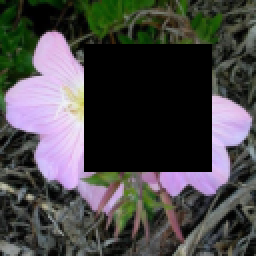

In [6]:
from PIL import Image
original_img.resize((original_img.width * 2,original_img.height * 2),
                                                    Image.NEAREST)


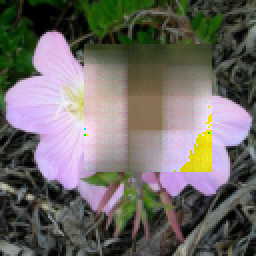

In [7]:
completed_img.resize((completed_img.width * 2,completed_img.height * 2),
                                                    Image.NEAREST)

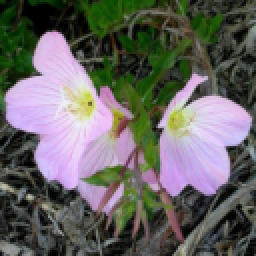

In [8]:
true_img.resize((true_img.width * 2,true_img.height * 2),
                                                    Image.NEAREST)


## Downstream evaluation

In the SSL model trained above, we have multiple encoders. All of these specialize in capturing the information at a specific level.

In [74]:
torch.save(model.state_dict(), 'ssl_model.pth')

In [43]:
model.load_state_dict(torch.load('ssl_model.pth'))

input_shape = (256, 128, 128)
# Define the classification model
classification_model = nn.Sequential(
    # Convolutional layers
    nn.AdaptiveAvgPool2d((1, 1)),
#     # Flatten the feature maps
    nn.Flatten(),

#     # Fully connected layers
    nn.Linear(num_scales*512, 256),
    nn.ReLU(),
    nn.Linear(256, 102)  # num_classes is the number of classes for classification
)


def model_eval(model, classification_model, dataloader):
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            
            encoder_outputs = []
            for j in range(num_scales):
                encoder_outputs.append(model.encoders[j](images))
            encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
            outputs = classification_model(encoder_outputs_stacked)
        
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
#             print(predicted.shape, labels.shape, total, images.shape, outputs.data.shape)
#             print(encoder_outputs_stacked.shape)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam([{'params': classification_model.parameters()}, {'params': model.parameters()}], lr=learning_rate)

num_epochs = 50
classification_model = classification_model.to(device)

log_train_every = 1
log_test_every = 5

trainLoss_ssl, trainAcc_ssl, testAcc_ssl = [], [], []

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        encoder_outputs = []
        for j in range(num_scales):
            encoder_outputs.append(model.encoders[j](inputs))
        encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
        outputs = classification_model(encoder_outputs_stacked)
        
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # compute training & testing accuracy every couple of iterations        
    if (epoch+1) % log_train_every == 0:
        train_accuracy = model_eval(model, classification_model, train_loader)

        # Log the loss
        #writer.add_scalar('Loss/train', loss.cpu().item(), epoch * len(train_loader) + i)

        # Log the training accuracy
        #writer.add_scalar('Accuracy/train', train_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Loss: {running_loss} Accuracy: {train_accuracy}")
        trainLoss.append(running_loss)
        trainAcc.append(train_accuracy)
        
    if (epoch+1) % log_test_every == 0:
        test_accuracy = model_eval(model, classification_model, test_dataloader)

        # Log the test accuracy
        #writer.add_scalar('Accuracy/test', test_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Test Accuracy: {test_accuracy}")
        testAcc.append(test_accuracy)
        
# writer.close()
print("Training finished.")

Epoch 1 : Loss: 74.10520553588867 Accuracy: 2.7450980392156863
Epoch 2 : Loss: 72.35587692260742 Accuracy: 3.0392156862745097
Epoch 3 : Loss: 66.9827048778534 Accuracy: 6.176470588235294
Epoch 4 : Loss: 62.56701612472534 Accuracy: 8.333333333333334
Epoch 5 : Loss: 59.38990068435669 Accuracy: 13.529411764705882
Epoch 5 : Test Accuracy: 9.221011546592942
Epoch 6 : Loss: 55.637062072753906 Accuracy: 19.313725490196077
Epoch 7 : Loss: 52.91266489028931 Accuracy: 20.49019607843137
Epoch 8 : Loss: 51.35906934738159 Accuracy: 19.313725490196077
Epoch 9 : Loss: 49.338528633117676 Accuracy: 27.745098039215687
Epoch 10 : Loss: 46.08248829841614 Accuracy: 30.686274509803923
Epoch 10 : Test Accuracy: 15.970076435192714
Epoch 11 : Loss: 42.5757942199707 Accuracy: 35.588235294117645
Epoch 12 : Loss: 40.502734899520874 Accuracy: 39.11764705882353


KeyboardInterrupt: 

In [39]:
import re
log="""
Epoch 1 : Loss: 74.20960330963135 Accuracy: 3.823529411764706
Epoch 2 : Loss: 72.39738750457764 Accuracy: 3.3333333333333335
Epoch 3 : Loss: 67.17751169204712 Accuracy: 8.72549019607843
Epoch 4 : Loss: 62.226592779159546 Accuracy: 9.901960784313726
Epoch 5 : Loss: 57.941147565841675 Accuracy: 18.137254901960784
Epoch 5 : Test Accuracy: 10.359408033826638
Epoch 6 : Loss: 54.60170221328735 Accuracy: 16.07843137254902
Epoch 7 : Loss: 52.47191524505615 Accuracy: 23.529411764705884
Epoch 8 : Loss: 48.571633100509644 Accuracy: 25.19607843137255
Epoch 9 : Loss: 47.159404039382935 Accuracy: 25.19607843137255
Epoch 10 : Loss: 44.16832780838013 Accuracy: 32.64705882352941
Epoch 10 : Test Accuracy: 16.799479590177263
Epoch 11 : Loss: 41.9867742061615 Accuracy: 36.1764705882353
Epoch 12 : Loss: 38.29439973831177 Accuracy: 39.21568627450981
Epoch 13 : Loss: 37.31682562828064 Accuracy: 46.96078431372549
Epoch 14 : Loss: 33.15226709842682 Accuracy: 51.1764705882353
Epoch 15 : Loss: 30.269101977348328 Accuracy: 51.27450980392157
Epoch 15 : Test Accuracy: 20.377297121483167
Epoch 16 : Loss: 28.190056562423706 Accuracy: 55.78431372549019
Epoch 17 : Loss: 25.801210045814514 Accuracy: 56.1764705882353
Epoch 18 : Loss: 24.36522936820984 Accuracy: 65.98039215686275
Epoch 19 : Loss: 20.998403310775757 Accuracy: 66.66666666666667
Epoch 20 : Loss: 18.38445085287094 Accuracy: 76.07843137254902
Epoch 20 : Test Accuracy: 21.93852658968938
Epoch 21 : Loss: 14.421349465847015 Accuracy: 77.45098039215686
Epoch 22 : Loss: 12.948252081871033 Accuracy: 75.88235294117646
Epoch 23 : Loss: 11.27663391828537 Accuracy: 82.3529411764706
Epoch 24 : Loss: 9.624051004648209 Accuracy: 86.96078431372548
Epoch 25 : Loss: 8.787111073732376 Accuracy: 89.01960784313725
Epoch 25 : Test Accuracy: 23.56480728573752
Epoch 26 : Loss: 7.5773062109947205 Accuracy: 92.6470588235294
Epoch 27 : Loss: 6.321688711643219 Accuracy: 90.49019607843137
Epoch 28 : Loss: 6.6004891991615295 Accuracy: 90.98039215686275
Epoch 29 : Loss: 5.725588694214821 Accuracy: 92.25490196078431
Epoch 30 : Loss: 3.309836558997631 Accuracy: 96.86274509803921
Epoch 30 : Test Accuracy: 23.207025532606927
Training finished.
"""
pattern = r"Test Accuracy: (\d+\.\d+)"
test_accuracies_ssl = re.findall(pattern, log)
test_accuracies_ssl = [float(t) for t in test_accuracies_ssl]
test_accuracies_ssl

[10.359408033826638,
 16.799479590177263,
 20.377297121483167,
 21.93852658968938,
 23.56480728573752,
 23.207025532606927]

## Training without SSL

In [23]:
for i in range(num_scales):
    model.encoders[i] = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
        nn.ReLU()
    )

classification_model_nonssl = nn.Sequential(
    # Convolutional layers
    nn.AdaptiveAvgPool2d((1, 1)),
#     # Flatten the feature maps
    nn.Flatten(),

#     # Fully connected layers
    nn.Linear(num_scales*512, 256),
    nn.ReLU(),
    nn.Linear(256, 102)  # num_classes is the number of classes for classification
)

def model_eval_nonssl(model, classification_model, dataloader):
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            
            encoder_outputs = []
            for j in range(num_scales):
                encoder_outputs.append(model.encoders[j](images))
            encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
            outputs = classification_model(encoder_outputs_stacked)
        
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
#             print(predicted.shape, labels.shape, total, images.shape, outputs.data.shape)
#             print(encoder_outputs_stacked.shape)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


num_epochs = 30
classification_model = classification_model.to(device)
model = model.to(device)

log_train_every = 1
log_test_every = 5

trainLoss_nonssl, trainAcc_nonssl, testAcc_nonssl = [], [], []

criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam([{'params': classification_model.parameters()}, {'params': model.parameters()}], lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        encoder_outputs = []
        for j in range(num_scales):
            encoder_outputs.append(model.encoders[j](inputs))
        encoder_outputs_stacked = torch.cat(encoder_outputs, dim=1)
        outputs = classification_model(encoder_outputs_stacked)
        
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # compute training & testing accuracy every couple of iterations        
    if (epoch+1) % log_train_every == 0:
        train_accuracy = model_eval(model, classification_model, train_loader)

        # Log the loss
        #writer.add_scalar('Loss/train', loss.cpu().item(), epoch * len(train_loader) + i)

        # Log the training accuracy
        #writer.add_scalar('Accuracy/train', train_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Loss: {running_loss} Accuracy: {train_accuracy}")
        trainLoss_ssl.append(running_loss)
        trainAcc_nonssl.append(train_accuracy)
        
    if (epoch+1) % log_test_every == 0:
        test_accuracy = model_eval(model, classification_model, test_dataloader)
        testAcc_nonssl.append(test_accuracy)

        # Log the test accuracy
        #writer.add_scalar('Accuracy/test', test_accuracy, epoch * len(train_loader) + i)
        print(f"Epoch {epoch+1} : Test Accuracy: {test_accuracy}")
        
# writer.close()
print("Training finished.")

Epoch 1 : Loss: 71.74733972549438 Accuracy: 2.2549019607843137
Epoch 2 : Loss: 65.23740196228027 Accuracy: 6.470588235294118
Epoch 3 : Loss: 59.61262822151184 Accuracy: 9.509803921568627
Epoch 4 : Loss: 56.705787658691406 Accuracy: 14.019607843137255
Epoch 5 : Loss: 53.51545071601868 Accuracy: 18.235294117647058
Epoch 5 : Test Accuracy: 12.343470483005367
Epoch 6 : Loss: 50.583171129226685 Accuracy: 22.54901960784314
Epoch 7 : Loss: 47.38160681724548 Accuracy: 26.568627450980394
Epoch 8 : Loss: 45.27287578582764 Accuracy: 26.764705882352942
Epoch 9 : Loss: 43.961976051330566 Accuracy: 30.686274509803923
Epoch 10 : Loss: 41.728328227996826 Accuracy: 30.686274509803923
Epoch 10 : Test Accuracy: 15.173198894129127
Epoch 11 : Loss: 40.44138836860657 Accuracy: 36.07843137254902
Epoch 12 : Loss: 38.884626388549805 Accuracy: 38.431372549019606
Epoch 13 : Loss: 38.7421293258667 Accuracy: 39.21568627450981
Epoch 14 : Loss: 35.663479924201965 Accuracy: 43.627450980392155
Epoch 15 : Loss: 33.1832

In [40]:
log="""
Epoch 1 : Loss: 71.74733972549438 Accuracy: 2.2549019607843137
Epoch 2 : Loss: 65.23740196228027 Accuracy: 6.470588235294118
Epoch 3 : Loss: 59.61262822151184 Accuracy: 9.509803921568627
Epoch 4 : Loss: 56.705787658691406 Accuracy: 14.019607843137255
Epoch 5 : Loss: 53.51545071601868 Accuracy: 18.235294117647058
Epoch 5 : Test Accuracy: 12.343470483005367
Epoch 6 : Loss: 50.583171129226685 Accuracy: 22.54901960784314
Epoch 7 : Loss: 47.38160681724548 Accuracy: 26.568627450980394
Epoch 8 : Loss: 45.27287578582764 Accuracy: 26.764705882352942
Epoch 9 : Loss: 43.961976051330566 Accuracy: 30.686274509803923
Epoch 10 : Loss: 41.728328227996826 Accuracy: 30.686274509803923
Epoch 10 : Test Accuracy: 15.173198894129127
Epoch 11 : Loss: 40.44138836860657 Accuracy: 36.07843137254902
Epoch 12 : Loss: 38.884626388549805 Accuracy: 38.431372549019606
Epoch 13 : Loss: 38.7421293258667 Accuracy: 39.21568627450981
Epoch 14 : Loss: 35.663479924201965 Accuracy: 43.627450980392155
Epoch 15 : Loss: 33.18328046798706 Accuracy: 41.666666666666664
Epoch 15 : Test Accuracy: 18.8648560741584
Epoch 16 : Loss: 32.30304181575775 Accuracy: 48.03921568627451
Epoch 17 : Loss: 30.459790468215942 Accuracy: 48.333333333333336
Epoch 18 : Loss: 29.15789544582367 Accuracy: 50.78431372549019
Epoch 19 : Loss: 28.281601071357727 Accuracy: 49.6078431372549
Epoch 20 : Loss: 28.99619686603546 Accuracy: 56.1764705882353
Epoch 20 : Test Accuracy: 21.743372906163604
Epoch 21 : Loss: 25.570492386817932 Accuracy: 59.11764705882353
Epoch 22 : Loss: 24.774168252944946 Accuracy: 55.294117647058826
Epoch 23 : Loss: 24.31271719932556 Accuracy: 64.01960784313725
Epoch 24 : Loss: 20.26229476928711 Accuracy: 65.49019607843137
Epoch 25 : Loss: 19.550149500370026 Accuracy: 65.29411764705883
Epoch 25 : Test Accuracy: 23.158237111725484
Epoch 26 : Loss: 19.531396329402924 Accuracy: 68.92156862745098
Epoch 27 : Loss: 18.006486296653748 Accuracy: 72.54901960784314
Epoch 28 : Loss: 15.50946170091629 Accuracy: 73.72549019607843
Epoch 29 : Loss: 15.501207113265991 Accuracy: 66.47058823529412
Epoch 30 : Loss: 15.61135745048523 Accuracy: 75.7843137254902
Epoch 30 : Test Accuracy: 22.65409009595056
Training finished."""

pattern = r"Test Accuracy: (\d+\.\d+)"
test_accuracies_nonssl = re.findall(pattern, log)
test_accuracies_nonssl = [float(t) for t in test_accuracies_nonssl]
test_accuracies_nonssl

[12.343470483005367,
 15.173198894129127,
 18.8648560741584,
 21.743372906163604,
 23.158237111725484,
 22.65409009595056]

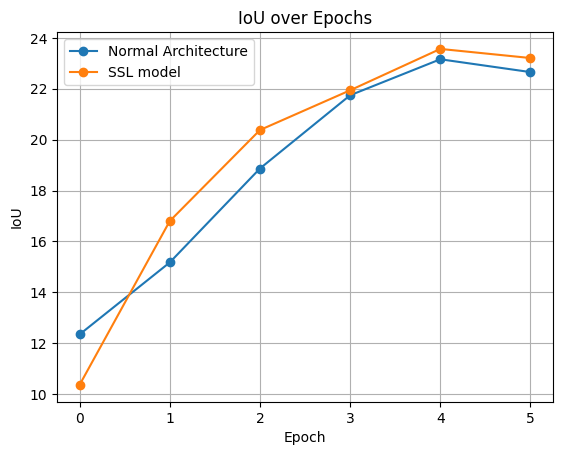

In [41]:
import matplotlib.pyplot as plt

epochs = range(6)

plt.plot(epochs, test_accuracies_nonssl, marker='o', label='Normal Architecture')
plt.plot(epochs, test_accuracies_ssl, marker='o', label='SSL model')

plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU over Epochs')
plt.legend()
plt.grid(True)
plt.show()